In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

#### Data
Data is preprocessed version of **House Prices - Advanced Regression Techniques** from Kaggle 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Therefore it is ready to be trained without any missing value or string feature

In [2]:
train = pd.read_csv('df_train.csv', index_col = 0)
test = pd.read_csv('df_test.csv', index_col = 0)

#### Task
Network will be trained for 2 tasks:
- Classify SaleCondition category
- Regress house prices
    - in last layer
    - in intermediate layer

In [3]:
y_cat = train.iloc[:, -7:-1].values #.idxmax(axis=1).values
y_cat_test = test.iloc[:, -6:].values #.idxmax(axis=1)

y_num = train.loc[:, 'price'].values

In [4]:
X_train = train.loc[:, ~train.columns.str.contains('SaleCondition_')].drop('price', axis = 1).values
X_test = test.loc[:, ~test.columns.str.contains('SaleCondition_')].values

#### Train-Dev-Test splits

In [5]:
X_train, X_dev, y_train_num, y_dev_num, y_train_cat, y_dev_cat = train_test_split(X_train, y_num, y_cat, 
                                                                                  test_size = 0.20, random_state = 0, stratify = y_cat)

#### Scaling

In [6]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_dev = scaler_X.transform(X_dev)

scaler_y = StandardScaler()
y_train_num = scaler_y.fit_transform(y_train_num.reshape(-1, 1)).reshape(-1)
y_dev_num = scaler_y.transform(y_dev_num.reshape(-1, 1)).reshape(-1)

#### Model

In [7]:
input_layer = tf.keras.layers.Input(shape = X_train.shape[1])
first_dense_layer = tf.keras.layers.Dense(X_train.shape[1] * 2, activation = 'tanh')(input_layer)
second_dense_layer = tf.keras.layers.Dense(X_train.shape[1] * 4, activation = 'tanh')(first_dense_layer)
third_dense_layer = tf.keras.layers.Dense(X_train.shape[1], activation = 'tanh')(second_dense_layer)
cat_out_layer = tf.keras.layers.Dense(y_train_cat.shape[1], activation = 'softmax', name = 'cat_out')(third_dense_layer)
num_out_layer = tf.keras.layers.Dense(1, activation = 'linear', name = 'num_out')(third_dense_layer)
int_num_out_layer = tf.keras.layers.Dense(1, activation ='linear', name ='int_num_out')(second_dense_layer)

model = tf.keras.Model(inputs = input_layer, outputs = [cat_out_layer, num_out_layer, int_num_out_layer])

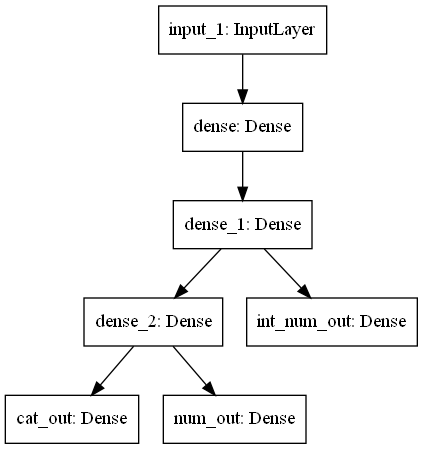

In [8]:
tf.keras.utils.plot_model(model)

Network has **3 output layers**.
- cat_out: Classifies SaleCondition of house
- num_out: Regresses house price on last layer
- int_num_out: Regresses house price on intermediate layer

Therefore network will be trained with a total loss of 3 distinct loss functions.
- Categorical Cross Entropy
- Mean Squared Error
- Mean Squared Error

In [9]:
model.compile(optimizer = 'adam',loss = {'cat_out': 'categorical_crossentropy',
                                         'num_out': 'mean_squared_error',
                                         'int_num_out': 'mean_squared_error'}, loss_weights = [1,1,1],
              metrics = {'cat_out': 'accuracy',
                         'num_out': 'mean_squared_error',
                         'int_num_out': 'mean_squared_error'})

In [10]:
history = model.fit(x = X_train, y = {'cat_out': y_train_cat,
                            'num_out': y_train_num,
                            'int_num_out': y_train_num}, validation_data= (X_dev, {'cat_out': y_dev_cat, 
                                                                                   'num_out': y_dev_num,
                                                                                   'int_num_out': y_dev_num}),
          batch_size = 128, epochs = 10, verbose = 0)

In [11]:
df_history = pd.DataFrame(history.history)

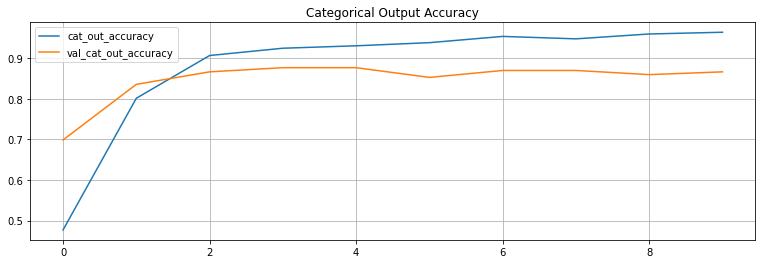

In [12]:
f, ax = plt.subplots(figsize = (13, 4))
df_history.loc[:, ['cat_out_accuracy', 'val_cat_out_accuracy']].plot(ax = ax)
ax.legend()
ax.set_title('Categorical Output Accuracy')
ax.grid()

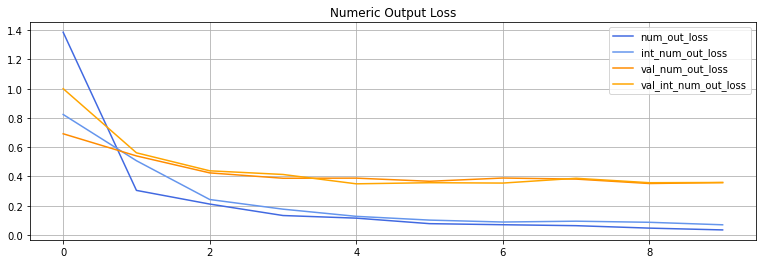

In [13]:
f, ax = plt.subplots(figsize = (13, 4))
cols_to_plot = ['num_out_loss', 'int_num_out_loss', 'val_num_out_loss', 'val_int_num_out_loss']
colors = ['royalblue', 'cornflowerblue', 'darkorange', 'orange']
for idx, col in enumerate(cols_to_plot):
    ax.plot(df_history.loc[:, col], color = colors[idx], label = col)
ax.legend()
ax.set_title('Numeric Output Loss')
ax.grid()